# Technical Analysis Trading Strategy

This notebook implements a trading strategy using four technical indicators:
1. RSI (Relative Strength Index)
2. Range Detector
3. McGinley Dynamic
4. Damiani Volatility

The strategy combines these indicators to generate trading signals with proper risk management.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# For plotting
plt.style.use('classic')  # Using a built-in style
plt.rcParams['figure.figsize'] = (15, 8)

In [2]:
# Load stock data from yfinance
def fetch_stock_data(symbol, period="2y", interval="1d"):
    """
    Fetch stock data from yfinance with error handling
    
    Parameters:
    symbol (str): Stock symbol (e.g., 'AAPL', 'MSFT', 'GOOGL', 'SPY')
    period (str): Data period ('1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max')
    interval (str): Data interval ('1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo')
    """
    try:
        print(f"📈 Fetching {period} of {interval} data for {symbol}...")
        ticker = yf.Ticker(symbol)
        df = ticker.history(period=period, interval=interval)
        
        if df.empty:
            raise ValueError(f"No data found for symbol {symbol}")
        
        # Basic preprocessing
        df = df[df['Volume'] != 0]  # Remove zero volume days
        df.columns = [col.lower() for col in df.columns]  # Lowercase columns
        
        print(f"✅ Successfully loaded {len(df)} data points")
        print(f"📅 Date range: {df.index[0].date()} to {df.index[-1].date()}")
        print(f"💰 Price range: ${df['close'].min():.2f} - ${df['close'].max():.2f}")
        
        return df
        
    except Exception as e:
        print(f"❌ Error fetching data: {e}")
        print("💡 Try different symbols like: AAPL, MSFT, GOOGL, TSLA, NVDA, SPY, QQQ")
        return None

# Configuration - Change these parameters as needed
SYMBOL = 'SPY'      # Stock symbol to analyze
PERIOD = '2y'        # Data period (1y, 2y, 5y, etc.)
INTERVAL = '1d'      # Data interval (1d for daily, 1h for hourly, etc.)

# Fetch the data
df = fetch_stock_data(SYMBOL, period=PERIOD, interval=INTERVAL)

if df is not None:
    print(f"\n📊 Data Summary for {SYMBOL}:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nFirst 5 rows:")
    print(df.head())
    print(f"\nLast 5 rows:")
    print(df.tail())
    
    # Check for missing values
    print(f"\nMissing values:")
    print(df.isna().sum())
else:
    print("❌ Failed to load data. Please check your internet connection and symbol.")


📈 Fetching 2y of 1d data for SPY...
✅ Successfully loaded 502 data points
📅 Date range: 2023-10-16 to 2025-10-15
💰 Price range: $400.33 - $673.11

📊 Data Summary for SPY:
Shape: (502, 8)
Columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'capital gains']

First 5 rows:
                                 open        high         low       close  \
Date                                                                        
2023-10-16 00:00:00-04:00  422.890646  426.127011  422.646944  425.054718   
2023-10-17 00:00:00-04:00  421.906096  427.101833  421.555180  425.035217   
2023-10-18 00:00:00-04:00  423.251262  424.216311  418.279742  419.371521   
2023-10-19 00:00:00-04:00  420.092882  421.915765  415.004390  415.686737   
2023-10-20 00:00:00-04:00  415.248159  415.794049  410.471583  410.578827   

                              volume  dividends  stock splits  capital gains  
Date                                                                          
20

Displaying Cumulative Strategy Returns Chart


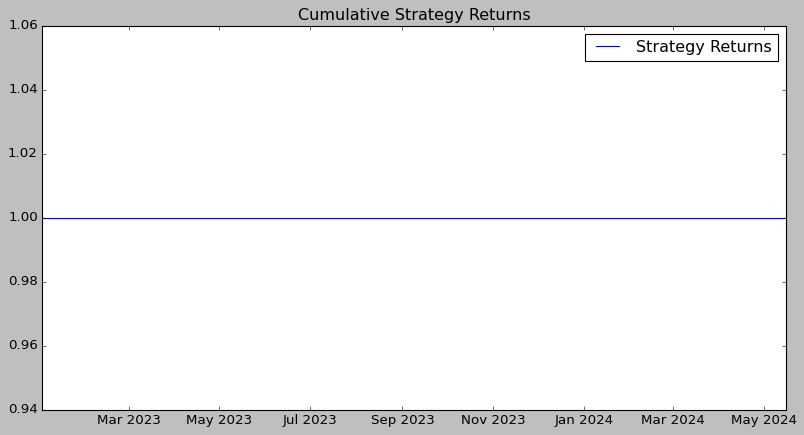

Displaying Trading Strategy Signals Chart


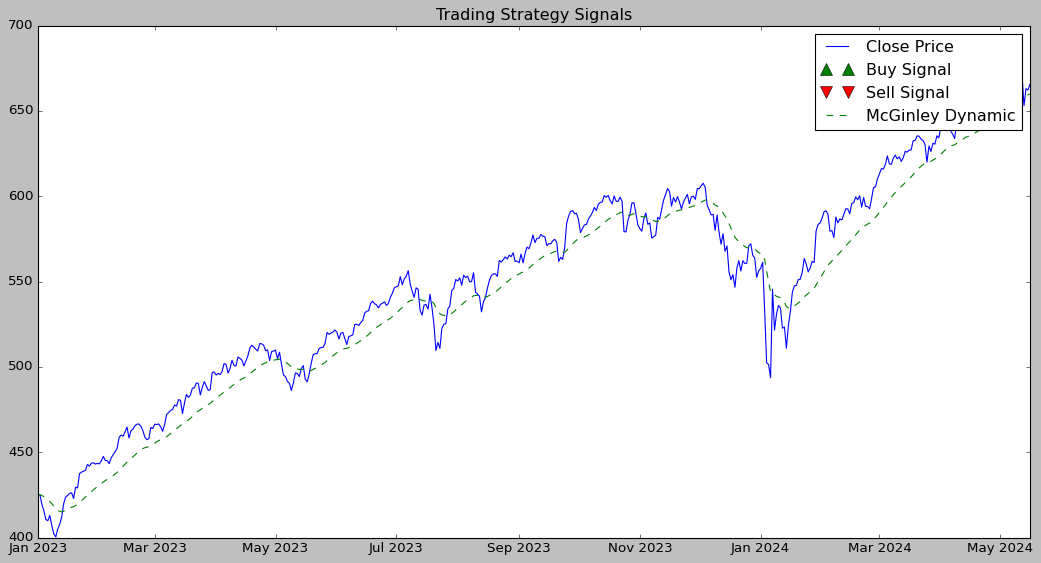

\n--- Strategy Data ---
                  open        high         low       close     volume  \
2024-05-12  673.530029  673.940002  669.210022  671.159973   66501900   
2024-05-13  672.130005  673.950012  652.840027  653.020020  159422600   
2024-05-14  660.650024  665.130005  659.770020  663.039978   79560500   
2024-05-15  657.169983  665.830017  653.169983  662.229980   88649600   
2024-05-16  666.820007  670.229980  663.914978  665.544983   31680563   

            dividends  stock splits  capital gains        rsi    mcginley  \
2024-05-12        0.0           0.0            0.0  66.369427  659.403919   
2024-05-13        0.0           0.0            0.0  42.498581  658.929832   
2024-05-14        0.0           0.0            0.0  52.632831  659.216202   
2024-05-15        0.0           0.0            0.0  51.837479  659.427580   
2024-05-16        0.0           0.0            0.0  54.844900  659.848692   

            volatility_meter  threshold_level  signal   returns  \
2024-05

In [3]:
# 1. Install and Import Necessary Libraries
# You may need to run this command in your terminal or a notebook cell
# !pip install pandas numpy matplotlib pandas_ta

import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt


# 2. Load Data
df.index = pd.to_datetime(pd.date_range(start='2023-01-01', periods=len(df)))


# 3. Define Custom Indicators
def mcginley_dynamic(close_prices, n=14):
    md = pd.Series(index=close_prices.index, dtype='float64')
    md.iloc[0] = close_prices.iloc[0]
    for i in range(1, len(close_prices)):
        if md.iloc[i-1] != 0 and not pd.isna(md.iloc[i-1]):
            denominator = (n * (close_prices.iloc[i] / md.iloc[i-1]) ** 4)
            if denominator != 0:
                md.iloc[i] = md.iloc[i-1] + (close_prices.iloc[i] - md.iloc[i-1]) / denominator
            else:
                md.iloc[i] = md.iloc[i-1]
        else:
            md.iloc[i] = close_prices.iloc[i]
    return md

def damiani_volatmeter(high, low, close, viscosity=7, sedimentation=50, threshold_level=1.1, matype='sma'):
    typical_price = (high + low + close) / 3
    atr_viscosity = ta.ATR(high, low, close, timeperiod=viscosity)
    atr_sedimentation = ta.ATR(high, low, close, timeperiod=sedimentation)
    vol = atr_viscosity / atr_sedimentation
    if matype.lower() == 'ema':
        ma_viscosity = typical_price.ewm(span=viscosity, adjust=False).mean()
        ma_sedimentation = typical_price.ewm(span=sedimentation, adjust=False).mean()
    elif matype.lower() == 'wma':
        ma_viscosity = ta.wma(typical_price, length=viscosity)
        ma_sedimentation = ta.wma(typical_price, length=sedimentation)
    else: 
        ma_viscosity = typical_price.rolling(window=viscosity).mean()
        ma_sedimentation = typical_price.rolling(window=sedimentation).mean()
    anti = typical_price.rolling(window=viscosity).apply(lambda x: (x - ma_viscosity.loc[x.index]).std(), raw=False)
    sedi = typical_price.rolling(window=sedimentation).apply(lambda x: (x - ma_sedimentation.loc[x.index]).std(), raw=False)
    antithres = anti / sedi
    threshold = threshold_level - antithres
    result_df = pd.DataFrame({
        'volatility_meter': vol,
        'threshold_level': threshold
    }, index=close.index)
    return result_df

# 4. Calculate Indicators
df['rsi'] = ta.RSI(df['close'], timeperiod=14)
df['mcginley'] = mcginley_dynamic(df['close'], n=14)
damiani_df = damiani_volatmeter(df['high'], df['low'], df['close'])
df = pd.concat([df, damiani_df], axis=1)

# 5. Define the Trading Strategy
df['signal'] = 0
df.loc[(df['rsi'] < 40) & (df['close'] > df['mcginley']) & (df['volatility_meter'] > df['threshold_level']), 'signal'] = 1
df.loc[(df['rsi'] > 60) & (df['close'] < df['mcginley']) & (df['volatility_meter'] > df['threshold_level']), 'signal'] = -1

# 6. Backtesting
df['returns'] = df['close'].pct_change()
df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
cumulative_returns = (1 + df['strategy_returns']).cumprod()

print("Displaying Cumulative Strategy Returns Chart")
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Strategy Returns')
plt.title('Cumulative Strategy Returns')
plt.legend()
plt.show()

# 7. Visualize Trades
print("Displaying Trading Strategy Signals Chart")
plt.figure(figsize=(16, 8))
plt.plot(df['close'], label='Close Price')
plt.plot(df[df['signal'] == 1].index, df['close'][df['signal'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(df[df['signal'] == -1].index, df['close'][df['signal'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.plot(df['mcginley'], label='McGinley Dynamic', linestyle='--')
plt.title('Trading Strategy Signals')
plt.legend()
plt.show()

print("\\n--- Strategy Data ---")
print(df.tail())